## 1. Library Import
- ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º Î∂àÎü¨ÏòµÎãàÎã§.

In [1]:
# !pip install eli5==0.13.0
%pip install eli5==0.13.0


Note: you may need to restart the kernel to use updated packages.


In [2]:

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÇ¨Ïö©ÏùÑ ÏúÑÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨ÏûÖÎãàÎã§.
# !apt-get install -y fonts-nanum
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [3]:
!pip install lightgbm==4.0.0

In [4]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf ÌååÏùºÏù¥ Ï†ÄÏû•ÎêòÏñ¥ ÏûàÎäî Í≤ΩÎ°ú
    name='NanumBarunGothic')                        # Ïù¥ Ìè∞Ìä∏Ïùò ÏõêÌïòÎäî Ïù¥Î¶Ñ ÏÑ§Ï†ï
fm.fontManager.ttflist.insert(0, fe)              # MatplotlibÏóê Ìè∞Ìä∏ Ï∂îÍ∞Ä
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# Ï∂îÍ∞Ä

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb

# Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú Î∞è Ï†ïÏ†ú
import pandas as pd
import joblib
import os


# import eli5
# from eli5.sklearn import PermutationImportance

## 2. Data Load

#### 2.1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú

In [5]:
# ÌïÑÏöîÌïú Îç∞Ïù¥ÌÑ∞Î•º load ÌïòÍ≤†ÏäµÎãàÎã§. Í≤ΩÎ°úÎäî ÌôòÍ≤ΩÏóê ÎßûÍ≤å ÏßÄÏ†ïÌï¥Ï£ºÎ©¥ Îê©ÎãàÎã§.
train_path = '/data/ephemeral/home/house-price/data/train.csv'
test_path  = '/data/ephemeral/home/house-price/data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [6]:
# Train dataÏôÄ Test data shapeÏùÄ ÏïÑÎûòÏôÄ Í∞ôÏäµÎãàÎã§.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [8]:
# ================================================================= #
# ‚ú® [START] 1. Í∏àÎ¶¨ Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ïª¨ÎüºÎ™Ö Î≥ÄÍ≤Ω ÏΩîÎìú
# ================================================================= #

import pandas as pd
from io import StringIO

# Í∏àÎ¶¨ Îç∞Ïù¥ÌÑ∞ ÌååÏùº Í≤ΩÎ°ú
rate_path = '/data/ephemeral/home/house-price/data/bank.csv' # Ïó¨Í∏∞Ïóê 'bank.csv' ÌååÏùº Í≤ΩÎ°úÎ•º ÏßÄÏ†ïÌïòÏÑ∏Ïöî.

# Îç∞Ïù¥ÌÑ∞ Î°úÎìú (Ï≤´ Î≤àÏß∏ ÌñâÏùÄ ÏÑ§Î™ÖÏù¥ÎØÄÎ°ú Í±¥ÎÑàÎúÅÎãàÎã§)
try:
    dt_rate = pd.read_csv(rate_path, skiprows=1, encoding='utf-8')
except UnicodeDecodeError:
    dt_rate = pd.read_csv(rate_path, skiprows=1, encoding='cp949')


# --- 1. Ïª¨ÎüºÎ™Ö Î≥ÄÍ≤Ω ---
# ÏöîÏ≤≠ÌïòÏã† Ïù¥Î¶ÑÏúºÎ°ú Ïª¨ÎüºÎ™ÖÏùÑ ÏßÄÏ†ïÌï©ÎãàÎã§.
dt_rate.columns = ['Ïó∞Ïõî', 'ÌïúÍµ≠ÏùÄÌñâÍ∏àÎ¶¨', 'Ï†ïÎ∂Ä ÎåÄÏ∂ú Í∏àÎ¶¨', 'Íµ≠Í≥†Ï±Ñ', 'ÏÑúÏö∏ÏßÄÍ∞ÄÎ≥ÄÎèôÎ•†']


# --- 2. Îç∞Ïù¥ÌÑ∞ Ï†ïÏ†ú ---
# 'Ïó∞Ïõî' Ïª¨Îüº ÌòïÏãùÏùÑ "YYYY/MM"ÏóêÏÑú "YYYYMM"ÏúºÎ°ú Î≥ÄÍ≤ΩÌï©ÎãàÎã§.
dt_rate['Ïó∞Ïõî'] = dt_rate['Ïó∞Ïõî'].str.replace('/', '').astype(str)

# Î™®Îì† Í∏àÎ¶¨/ÏßÄÏàò Í¥ÄÎ†® Ïª¨ÎüºÏùÑ Ïà´ÏûêÎ°ú Î≥ÄÍ≤ΩÌï©ÎãàÎã§.
# (Ïà´ÏûêÎ°ú Î≥ÄÍ≤ΩÌï† Ïàò ÏóÜÎäî Í∞íÏùÄ Í≤∞Ï∏°Ïπò(NaN)Î°ú Ï≤òÎ¶¨Îê©ÎãàÎã§)
for col in ['ÌïúÍµ≠ÏùÄÌñâÍ∏àÎ¶¨', 'Ï†ïÎ∂Ä ÎåÄÏ∂ú Í∏àÎ¶¨', 'Íµ≠Í≥†Ï±Ñ', 'ÏÑúÏö∏ÏßÄÍ∞ÄÎ≥ÄÎèôÎ•†']:
    dt_rate[col] = pd.to_numeric(dt_rate[col], errors='coerce')


print("‚úÖ Í∏àÎ¶¨/ÏßÄÍ∞Ä Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï†ïÏ†ú ÏôÑÎ£å")
print('Îç∞Ïù¥ÌÑ∞ shape: ', dt_rate.shape)
print("\n--- Î≥ÄÍ≤ΩÎêú Ïª¨ÎüºÎ™Ö Î∞è Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå ---")
display(dt_rate.head())

# ================================================================= #
# ‚ú® [END] 1. Í∏àÎ¶¨ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏΩîÎìú
# ================================================================= #

‚úÖ Í∏àÎ¶¨/ÏßÄÍ∞Ä Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï†ïÏ†ú ÏôÑÎ£å
Îç∞Ïù¥ÌÑ∞ shape:  (201, 5)

--- Î≥ÄÍ≤ΩÎêú Ïª¨ÎüºÎ™Ö Î∞è Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå ---


Ïó∞Ïõî  ÌïúÍµ≠ÏùÄÌñâÍ∏àÎ¶¨  Ï†ïÎ∂Ä ÎåÄÏ∂ú Í∏àÎ¶¨   Íµ≠Í≥†Ï±Ñ  ÏÑúÏö∏ÏßÄÍ∞ÄÎ≥ÄÎèôÎ•†
0  200702     4.5      4.75  4.91    0.462
1  200703     4.5      4.75  4.79    0.402
2  200704     4.5      4.95  4.94    0.347
3  200705     4.5      4.95  5.10    0.342
4  200706     4.5      4.95  5.24    0.378

## 3. Data Preprocessing

- Î™®Îç∏ÎßÅ Ï†ÑÏóê Îç∞Ïù¥ÌÑ∞ ÎÇ¥ Í≤∞Ï∏°Ïπò, Ïù¥ÏÉÅÏπò Îì±ÏùÑ Ï†úÍ±∞ÌïòÍ≥† Î≤îÏ£ºÌòïÍ≥º Ïó∞ÏÜçÌòï Î≥ÄÏàòÎ•º ÏÇ¥Ìé¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§!
- Î®ºÏ†Ä, Ïö©Ïù¥Ìïú Ï†ÑÏ≤òÎ¶¨Î•º ÏúÑÌï¥ trainÍ≥º test dataÎ•º Ìï©Ïπú ÌïòÎÇòÏùò Îç∞Ïù¥ÌÑ∞Î°ú ÏßÑÌñâÌïòÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

In [9]:
# train/test Íµ¨Î∂ÑÏùÑ ÏúÑÌïú ÏπºÎüºÏùÑ ÌïòÎÇò ÎßåÎì§Ïñ¥ Ï§çÎãàÎã§.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # ÌïòÎÇòÏùò Îç∞Ïù¥ÌÑ∞Î°ú ÎßåÎì§Ïñ¥Ï§çÎãàÎã§.

In [10]:
concat['is_test'].value_counts()      # trainÍ≥º test dataÍ∞Ä ÌïòÎÇòÎ°ú Ìï©Ï≥êÏßÑ Í≤ÉÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

is_test
0    1118822
1       9272
Name: count, dtype: int64

In [11]:
# ÏπºÎüº Ïù¥Î¶ÑÏùÑ ÏâΩÍ≤å Î∞îÍøîÏ£ºÍ≤†ÏäµÎãàÎã§. Îã§Î•∏ ÏπºÎüºÎèÑ ÏÇ¨Ïö©Ïóê Îî∞Îùº Î∞îÍøîÏ£ºÏÖîÎèÑ Îê©ÎãàÎã§!
concat = concat.rename(columns={'Ï†ÑÏö©Î©¥Ï†Å(„é°)':'Ï†ÑÏö©Î©¥Ï†Å'})

In [15]:
# ÏúÑ Ï≤òÎüº ÏïÑÎ¨¥ ÏùòÎØ∏ÎèÑ Í∞ñÏßÄ ÏïäÎäî ÏπºÎüºÏùÄ Í≤∞Ï∏°ÏπòÏôÄ Í∞ôÏùÄ Ïó≠Ìï†ÏùÑ ÌïòÎØÄÎ°ú, np.nanÏúºÎ°ú Ï±ÑÏõå Í≤∞Ï∏°ÏπòÎ°ú Ïù∏ÏãùÎêòÎèÑÎ°ù Ìï©ÎãàÎã§.
concat['Îì±Í∏∞Ïã†Ï≤≠ÏùºÏûê'] = concat['Îì±Í∏∞Ïã†Ï≤≠ÏùºÏûê'].replace(' ', np.nan)
concat['Í±∞ÎûòÏú†Ìòï'] = concat['Í±∞ÎûòÏú†Ìòï'].replace('-', np.nan)
concat['Ï§ëÍ∞úÏÇ¨ÏÜåÏû¨ÏßÄ'] = concat['Ï§ëÍ∞úÏÇ¨ÏÜåÏû¨ÏßÄ'].replace('-', np.nan)

## 10ÎßåÍ∞ú Ïù¥ÏÉÅÎßå ÏÑ†ÌÉù

In [17]:
# ÏúÑÏóêÏÑú Í≤∞Ï∏°ÏπòÍ∞Ä 10ÎßåÍ∞ú Ïù¥ÌïòÏù∏ Î≥ÄÏàòÎì§Îßå Í≥®Îùº ÏÉàÎ°úÏö¥ concat_select Í∞ùÏ≤¥Î°ú Ï†ÄÏû•Ìï¥Ï§çÎãàÎã§.
selected = list(concat.columns[concat.isnull().sum() <= 100000])
concat_select = concat[selected]
# 100ÎßåÍ∞ú Í∏∞Ï§ÄÏùÑ 10ÎßåÍ∞úÎ°ú Î≥ÄÍ≤Ω 2024.7.17

In [18]:
selected = list(concat.columns[concat.isnull().sum() <= 100000])

# 2. Í∞ïÏ†úÎ°ú Ìè¨Ìï®ÌïòÍ≥† Ïã∂ÏùÄ Ïª¨Îüº ÏßÄÏ†ï
must_include = ["Ï¢åÌëúX", "Ï¢åÌëúY"]

# 3. Ìï©ÏπòÍ≥† Ï§ëÎ≥µ Ï†úÍ±∞
selected = list(set(selected + must_include))

# 4. ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ÏÖã
concat_select = concat[selected]

In [19]:
concat_select.columns

Index(['Î≤àÏßÄ', 'Ï∏µ', 'is_test', 'Í≥ÑÏïΩÎÖÑÏõî', 'Ï¢åÌëúY', 'ÏïÑÌååÌä∏Î™Ö', 'Í≥ÑÏïΩÏùº', 'Î≥∏Î≤à', 'Î∂ÄÎ≤à', 'Ï¢åÌëúX',
       'ÎèÑÎ°úÎ™Ö', 'Í±¥Ï∂ïÎÖÑÎèÑ', 'target', 'ÏãúÍµ∞Íµ¨', 'Ï†ÑÏö©Î©¥Ï†Å'],
      dtype='object')

In [20]:
concat_select.isnull().sum()     # Í≤∞Ï∏°ÏπòÍ∞Ä 10ÎßåÍ∞ú Ï¥àÍ≥ºÏù∏ ÏπºÎüºÏù¥ Ï†úÍ±∞Îêú Î™®ÏäµÏùÄ ÏïÑÎûòÏôÄ Í∞ôÏäµÎãàÎã§.
# targetÎ≥ÄÏàòÎäî test dataset Í∞úÏàòÎßåÌÅº(9272) Í≤∞Ï∏°ÏπòÍ∞Ä Ï°¥Ïû¨Ìï®ÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

Î≤àÏßÄ            227
Ï∏µ               0
is_test         0
Í≥ÑÏïΩÎÖÑÏõî            0
Ï¢åÌëúY        876232
ÏïÑÌååÌä∏Î™Ö         2136
Í≥ÑÏïΩÏùº             0
Î≥∏Î≤à             75
Î∂ÄÎ≤à             75
Ï¢åÌëúX        876232
ÎèÑÎ°úÎ™Ö             0
Í±¥Ï∂ïÎÖÑÎèÑ            0
target       9272
ÏãúÍµ∞Íµ¨             0
Ï†ÑÏö©Î©¥Ï†Å            0
dtype: int64

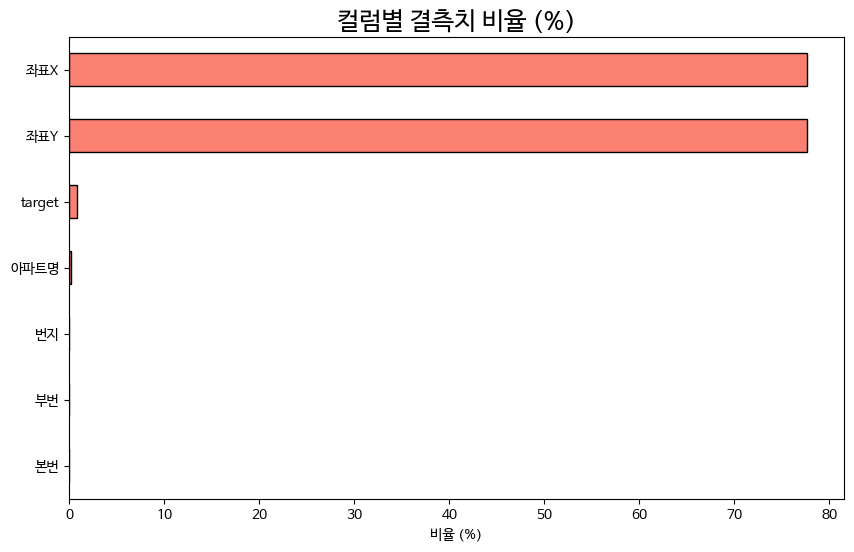

In [21]:
missing_percent = (concat_select.isnull().sum() / len(concat_select)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values()

plt.figure(figsize=(10,6))
missing_percent.plot(kind="barh", color="salmon", edgecolor="black")
plt.title("Ïª¨ÎüºÎ≥Ñ Í≤∞Ï∏°Ïπò ÎπÑÏú® (%)", fontsize=18)
plt.xlabel("ÎπÑÏú® (%)")
plt.show()

## Î≤àÏßÄ Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨

In [22]:
# Î≤àÏßÄ Îç∞Ïù¥ÌÑ∞ ÏàòÎèô ÏûëÏóÖ
concat.loc[concat['Î≤àÏßÄ'].isna(), ['ÏïÑÌååÌä∏Î™Ö']].value_counts()

ÏïÑÌååÌä∏Î™Ö         
ÏÑúÏ¥àÌè¨Î†àÏä§ÌÉÄ2Îã®ÏßÄ        152
ÌûêÏä§ÌÖåÏù¥Ìä∏ ÏÑúÏ¥à Ï††Ìä∏Î¶¨Ïä§     75
Name: count, dtype: int64

In [23]:
concat.loc[concat['ÏïÑÌååÌä∏Î™Ö']=='ÌûêÏä§ÌÖåÏù¥Ìä∏ ÏÑúÏ¥à Ï††Ìä∏Î¶¨Ïä§', 'ÏãúÍµ∞Íµ¨']


60194     ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÑúÏ¥àÍµ¨ Ïã†ÏõêÎèô
60195     ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÑúÏ¥àÍµ¨ Ïã†ÏõêÎèô
60196     ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÑúÏ¥àÍµ¨ Ïã†ÏõêÎèô
60197     ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÑúÏ¥àÍµ¨ Ïã†ÏõêÎèô
60198     ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÑúÏ¥àÍµ¨ Ïã†ÏõêÎèô
              ...      
720188    ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÑúÏ¥àÍµ¨ Ïã†ÏõêÎèô
720189    ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÑúÏ¥àÍµ¨ Ïã†ÏõêÎèô
720190    ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÑúÏ¥àÍµ¨ Ïã†ÏõêÎèô
720191    ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÑúÏ¥àÍµ¨ Ïã†ÏõêÎèô
720192    ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÑúÏ¥àÍµ¨ Ïã†ÏõêÎèô
Name: ÏãúÍµ∞Íµ¨, Length: 75, dtype: object

In [24]:
# ÏïÑÌååÌä∏Î™ÖÏóê ÎåÄÌïú Î≤àÏßÄ Îç∞Ïù¥ÌÑ∞ ÏûÖÎ†•
concat_select.loc[concat_select['ÏïÑÌååÌä∏Î™Ö'] == 'ÌûêÏä§ÌÖåÏù¥Ìä∏ ÏÑúÏ¥à Ï††Ìä∏Î¶¨Ïä§', 'Î≤àÏßÄ'] = '557'
concat_select.loc[concat_select['ÏïÑÌååÌä∏Î™Ö'] == 'ÏÑúÏ¥àÌè¨Î†àÏä§ÌÉÄ2Îã®ÏßÄ', 'Î≤àÏßÄ'] = '384'

In [25]:
concat_select.loc[concat_select['Î≤àÏßÄ'].isna(), ['ÏïÑÌååÌä∏Î™Ö']].value_counts()

Series([], Name: count, dtype: int64)

In [26]:
concat_select.isnull().sum()

Î≤àÏßÄ              0
Ï∏µ               0
is_test         0
Í≥ÑÏïΩÎÖÑÏõî            0
Ï¢åÌëúY        876232
ÏïÑÌååÌä∏Î™Ö         2136
Í≥ÑÏïΩÏùº             0
Î≥∏Î≤à             75
Î∂ÄÎ≤à             75
Ï¢åÌëúX        876232
ÎèÑÎ°úÎ™Ö             0
Í±¥Ï∂ïÎÖÑÎèÑ            0
target       9272
ÏãúÍµ∞Íµ¨             0
Ï†ÑÏö©Î©¥Ï†Å            0
dtype: int64

## ÏïÑÌååÌä∏Î™Ö Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨

In [27]:
concat_select['ÏïÑÌååÌä∏Î™Ö'] = concat_select.groupby('ÎèÑÎ°úÎ™Ö')['ÏïÑÌååÌä∏Î™Ö'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

In [28]:
concat_select.isnull().sum()

Î≤àÏßÄ              0
Ï∏µ               0
is_test         0
Í≥ÑÏïΩÎÖÑÏõî            0
Ï¢åÌëúY        876232
ÏïÑÌååÌä∏Î™Ö         2130
Í≥ÑÏïΩÏùº             0
Î≥∏Î≤à             75
Î∂ÄÎ≤à             75
Ï¢åÌëúX        876232
ÎèÑÎ°úÎ™Ö             0
Í±¥Ï∂ïÎÖÑÎèÑ            0
target       9272
ÏãúÍµ∞Íµ¨             0
Ï†ÑÏö©Î©¥Ï†Å            0
dtype: int64

In [29]:
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'Ï≤úÌò∏ÎåÄÎ°ú77Îã§Í∏∏ 11-6', 'ÏïÑÌååÌä∏Î™Ö'] = 'Ìï¥Ïò§Î¶ÑÏïÑÌååÌä∏'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'ÎèôÌò∏Î°ú11ÎßàÍ∏∏ 20-8', 'ÏïÑÌååÌä∏Î™Ö'] = 'ÏÑ±ÎØºÏïÑÌä∏'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'Ïó¨ÏùòÎåÄÎ∞©Î°ú62Í∏∏ 24', 'ÏïÑÌååÌä∏Î™Ö'] = 'Ìö®ÏÑ±ÏïÑÌååÌä∏'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'Íµ≠ÏÇ¨Î¥â1Í∏∏ 18', 'ÏïÑÌååÌä∏Î™Ö'] = 'ÏÉÅÏßÑÎπåÎî©'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'ÎèôÌò∏Î°ú11Î∞îÍ∏∏ 30-8', 'ÏïÑÌååÌä∏Î™Ö'] = 'ÏÑùÏ¢ÖÏïÑÌååÌä∏'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'Ïã†ÏàòÎ°ú 89', 'ÏïÑÌååÌä∏Î™Ö'] = 'Ïã†ÏàòÎèô ÏûêÏù¥Ïñ∏Ìä∏ ÏïÑÌååÌä∏'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'ÏñëÏû¨ÎåÄÎ°ú71Í∏∏ 2-11', 'ÏïÑÌååÌä∏Î™Ö'] = 'Ïò¨Î¶ºÌîΩÏïÑÌä∏Îπå'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'Ï≤≠Í≥ÑÏ≤úÎ°ú 295', 'ÏïÑÌååÌä∏Î™Ö'] = 'ÎèôÎåÄÎ¨∏Ïã†Î∞úÏÉÅÍ∞Ä'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'ÎåÄÌïôÎ°ú7Í∏∏ 15-4', 'ÏïÑÌååÌä∏Î™Ö'] = 'Ïó∞Í±¥ÎèôÏïÑÌååÌä∏'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'Í∞ïÎÇ®ÎåÄÎ°ú27Í∏∏ 7-14', 'ÏïÑÌååÌä∏Î™Ö'] = 'ÌïúÏùºÏù∏ÌÖîÎπåÎùº'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'Î™ÖÎ•ú2Í∏∏ 9-14', 'ÏïÑÌååÌä∏Î™Ö'] = 'Î™ÖÎ•ú2Í∏∏ 9-14'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'ÎèôÌò∏Î°ú5Í∏∏ 12', 'ÏïÑÌååÌä∏Î™Ö'] = 'Îã§Îã§Ïú†ÌÅ¨Î†àÏä§'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'Ï¶ùÏÇ∞Î°ú23Í∏∏ 8-8', 'ÏïÑÌååÌä∏Î™Ö'] = 'Ïö∞ÏùºÏïÑÌååÌä∏'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'ÎÇôÏÇ∞ÏÑ±Í≥ΩÎèôÍ∏∏ 35-1', 'ÏïÑÌååÌä∏Î™Ö'] = 'ÎÇôÏÇ∞ÏÑ±Í≥ΩÎèôÍ∏∏ 35-1'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'ÏÑúÎ¶¨ÌíÄÍ∏∏ 14', 'ÏïÑÌååÌä∏Î™Ö'] = 'callia vill'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'Ìö®Î†πÎ°ú 200', 'ÏïÑÌååÌä∏Î™Ö'] = 'Ìö®Î†πÎ°ú 200'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'ÌôîÍ≥°Î°ú 176-5', 'ÏïÑÌååÌä∏Î™Ö'] = 'ÌôîÍ≥°Î°ú 176-5'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'Í¥ëÎÇòÎ£®Î°ú12Í∏∏ 5', 'ÏïÑÌååÌä∏Î™Ö'] = 'Í¥ëÎÇòÎ£®Î°ú12Í∏∏ 5'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'Í∞úÏö¥ÏÇ¨Í∏∏ 83-15', 'ÏïÑÌååÌä∏Î™Ö'] = 'Í∞úÏö¥ÏÇ¨Í∏∏ 83-15'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'ÎèÑÍ≥°Î°ú93Í∏∏ 23', 'ÏïÑÌååÌä∏Î™Ö'] = 'ÎåÄÏπò Î•¥Ïóò'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'ÍπåÏπòÏÇ∞Î°ú14Í∏∏ 26-13', 'ÏïÑÌååÌä∏Î™Ö'] = 'ÌûêÌÉëÏïÑÌååÌä∏'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'ÏñëÏ≤úÎ°ú 677', 'ÏïÑÌååÌä∏Î™Ö'] = 'ÏóºÏ∞ΩÌïòÏù¥Ï∏†ÎπåÎî©'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'Ï≤úÌò∏ÎåÄÎ°ú118Í∏∏ 10', 'ÏïÑÌååÌä∏Î™Ö'] = 'Ï≤úÌò∏ÎåÄÎ°ú118Í∏∏ 10'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'ÎÇúÍ≥ÑÎ°ú15Í∏∏ 36-6', 'ÏïÑÌååÌä∏Î™Ö'] = 'ÎÇúÍ≥ÑÎ°ú15Í∏∏ 36-6'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'ÎÇúÍ≥ÑÎ°ú15Í∏∏ 36-8', 'ÏïÑÌååÌä∏Î™Ö'] = 'ÎÇúÍ≥ÑÎ°ú15Í∏∏ 36-8'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'Ïù¥Î¨∏Î°ú35ÏïÑÍ∏∏ 16', 'ÎèÑÎ°úÎ™Ö'] = 'Ïù¥Î¨∏Î°ú16Í∏∏ 35' 
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'Ïù¥Î¨∏Î°ú16Í∏∏ 35', 'ÏïÑÌååÌä∏Î™Ö'] = 'Ïù¥Î¨∏Î°ú16Í∏∏ 35'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'ÎßàÏ°∞Î°ú1Í∏∏ 45', 'ÏïÑÌååÌä∏Î™Ö'] = 'ÏïÑÌååÌä∏'
concat_select.loc[concat_select['ÎèÑÎ°úÎ™Ö'] == 'ÏÑ±ÏßÄ3Í∏∏ 7', 'ÏïÑÌååÌä∏Î™Ö'] = 'ÏÑ±ÏßÄ3Í∏∏ 7'

In [30]:
concat_select.isnull().sum()

Î≤àÏßÄ              0
Ï∏µ               0
is_test         0
Í≥ÑÏïΩÎÖÑÏõî            0
Ï¢åÌëúY        876232
ÏïÑÌååÌä∏Î™Ö         1822
Í≥ÑÏïΩÏùº             0
Î≥∏Î≤à             75
Î∂ÄÎ≤à             75
Ï¢åÌëúX        876232
ÎèÑÎ°úÎ™Ö             0
Í±¥Ï∂ïÎÖÑÎèÑ            0
target       9272
ÏãúÍµ∞Íµ¨             0
Ï†ÑÏö©Î©¥Ï†Å            0
dtype: int64

In [31]:
concat_select['ÏïÑÌååÌä∏Î™Ö'] = concat_select.apply(lambda row: row['ÎèÑÎ°úÎ™Ö'] if (row['ÏãúÍµ∞Íµ¨'] == 'ÏÑúÏö∏ÌäπÎ≥ÑÏãú Íµ¨Î°úÍµ¨ Íµ¨Î°úÎèô' and pd.isna(row['ÏïÑÌååÌä∏Î™Ö']) and ('Íµ¨Î°úÎèôÎ°ú' in row['ÎèÑÎ°úÎ™Ö'] or 'ÎèÑÎ¶ºÎ°ú' in row['ÎèÑÎ°úÎ™Ö'] or 'ÎîîÏßÄÌÑ∏Î°ú' in row['ÎèÑÎ°úÎ™Ö'])) else row['ÏïÑÌååÌä∏Î™Ö'], axis=1)

In [32]:
concat_select.isnull().sum()

Î≤àÏßÄ              0
Ï∏µ               0
is_test         0
Í≥ÑÏïΩÎÖÑÏõî            0
Ï¢åÌëúY        876232
ÏïÑÌååÌä∏Î™Ö          200
Í≥ÑÏïΩÏùº             0
Î≥∏Î≤à             75
Î∂ÄÎ≤à             75
Ï¢åÌëúX        876232
ÎèÑÎ°úÎ™Ö             0
Í±¥Ï∂ïÎÖÑÎèÑ            0
target       9272
ÏãúÍµ∞Íµ¨             0
Ï†ÑÏö©Î©¥Ï†Å            0
dtype: int64

In [33]:
concat_select.loc[concat_select['ÏïÑÌååÌä∏Î™Ö'].isna(),['Î≤àÏßÄ','ÏãúÍµ∞Íµ¨', 'ÎèÑÎ°úÎ™Ö']].value_counts()
# Ïó¨Í∏∞ÏÑúÎ∂ÄÌÑ∞ Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨ÌïòÏûê

Î≤àÏßÄ       ÏãúÍµ∞Íµ¨             ÎèÑÎ°úÎ™Ö        
1101-1   ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏòÅÎì±Ìè¨Íµ¨ ÎåÄÎ¶ºÎèô  ÎèÑÎ¶ºÏ≤úÎ°ú19Í∏∏ 12     127
404-13   ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÎèôÎåÄÎ¨∏Íµ¨ Ïû•ÏïàÎèô  Ï≤úÌò∏ÎåÄÎ°ú77Í∏∏ 62      22
685-103  ÏÑúÏö∏ÌäπÎ≥ÑÏãú Í¥ÄÏïÖÍµ¨ Î¥âÏ≤úÎèô   ÎãπÍ≥°2Í∏∏ 109-11     21
828-76   ÏÑúÏö∏ÌäπÎ≥ÑÏãú Í∞ïÎÇ®Íµ¨ Ïó≠ÏÇºÎèô   ÌÖåÌó§ÎûÄÎ°ú10Í∏∏ 27      16
828-21   ÏÑúÏö∏ÌäπÎ≥ÑÏãú Í∞ïÎÇ®Íµ¨ Ïó≠ÏÇºÎèô   ÌÖåÌó§ÎûÄÎ°ú10Í∏∏ 25      14
Name: count, dtype: int64

In [35]:
concat_select.loc[(concat_select['ÎèÑÎ°úÎ™Ö'] == 'ÎèÑÎ¶ºÏ≤úÎ°ú19Í∏∏ 12') & (concat_select['Î≤àÏßÄ'] == '1101-1') , 'ÏïÑÌååÌä∏Î™Ö']

82632     NaN
82633     NaN
82634     NaN
82635     NaN
82636     NaN
         ... 
835844    NaN
900290    NaN
900291    NaN
8041      NaN
8042      NaN
Name: ÏïÑÌååÌä∏Î™Ö, Length: 127, dtype: object

ÏïÑÌååÌä∏ Í≤∞Ï∏°Ïπò ÏàòÎèôÏûëÏóÖ

In [36]:
concat_select.loc[(concat_select['ÎèÑÎ°úÎ™Ö'] == 'ÎèÑÎ¶ºÏ≤úÎ°ú19Í∏∏ 12') & (concat_select['Î≤àÏßÄ'] == '1101-1') , 'ÏïÑÌååÌä∏Î™Ö'] = 'Ïú†ÌÉëÏú†Î∏îÎ†àÏä§'
concat_select.loc[(concat_select['ÎèÑÎ°úÎ™Ö'] == 'Ï≤úÌò∏ÎåÄÎ°ú77Í∏∏ 62') & (concat_select['Î≤àÏßÄ'] == '404-13') , 'ÏïÑÌååÌä∏Î™Ö'] = 'INSÏÉàÌÑ∞ÏïÑÌååÌä∏'
concat_select.loc[(concat_select['ÎèÑÎ°úÎ™Ö'] == 'ÎãπÍ≥°2Í∏∏ 109-11') & (concat_select['Î≤àÏßÄ'] == '685-103') , 'ÏïÑÌååÌä∏Î™Ö'] = 'Î≥¥ÎûåÏïÑÌååÌä∏'
concat_select.loc[(concat_select['ÎèÑÎ°úÎ™Ö'] == 'ÌÖåÌó§ÎûÄÎ°ú10Í∏∏ 27') & (concat_select['Î≤àÏßÄ'] == '828-76') , 'ÏïÑÌååÌä∏Î™Ö'] = 'Îú®ÎùºÎÑ§'
concat_select.loc[(concat_select['ÎèÑÎ°úÎ™Ö'] == 'ÌÖåÌó§ÎûÄÎ°ú10Í∏∏ 25') & (concat_select['Î≤àÏßÄ'] == '828-21') , 'ÏïÑÌååÌä∏Î™Ö'] = 'Îú®ÎùºÎÑ§'



In [37]:
concat_select.isnull().sum()

Î≤àÏßÄ              0
Ï∏µ               0
is_test         0
Í≥ÑÏïΩÎÖÑÏõî            0
Ï¢åÌëúY        876232
ÏïÑÌååÌä∏Î™Ö            0
Í≥ÑÏïΩÏùº             0
Î≥∏Î≤à             75
Î∂ÄÎ≤à             75
Ï¢åÌëúX        876232
ÎèÑÎ°úÎ™Ö             0
Í±¥Ï∂ïÎÖÑÎèÑ            0
target       9272
ÏãúÍµ∞Íµ¨             0
Ï†ÑÏö©Î©¥Ï†Å            0
dtype: int64

In [38]:
# Î≥∏Î≤à, Î∂ÄÎ≤àÏùò Í≤ΩÏö∞ floatÎ°ú ÎêòÏñ¥ÏûàÏßÄÎßå Î≤îÏ£ºÌòï Î≥ÄÏàòÏùò ÏùòÎØ∏Î•º Í∞ÄÏßÄÎØÄÎ°ú object(string) ÌòïÌÉúÎ°ú Î∞îÍæ∏Ïñ¥Ï£ºÍ≥† ÏïÑÎûò ÏûëÏóÖÏùÑ ÏßÑÌñâÌïòÍ≤†ÏäµÎãàÎã§.
concat_select['Î≥∏Î≤à'] = concat_select['Î≥∏Î≤à'].astype('str')
concat_select['Î∂ÄÎ≤à'] = concat_select['Î∂ÄÎ≤à'].astype('str')

In [39]:
# Î®ºÏ†Ä, Ïó∞ÏÜçÌòï Î≥ÄÏàòÏôÄ Î≤îÏ£ºÌòï Î≥ÄÏàòÎ•º ÏúÑ infoÏóê Îî∞Îùº Î∂ÑÎ¶¨Ìï¥Ï£ºÍ≤†ÏäµÎãàÎã§.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("Ïó∞ÏÜçÌòï Î≥ÄÏàò:", continuous_columns)
print("Î≤îÏ£ºÌòï Î≥ÄÏàò:", categorical_columns)

Ïó∞ÏÜçÌòï Î≥ÄÏàò: ['Ï∏µ', 'is_test', 'Í≥ÑÏïΩÎÖÑÏõî', 'Ï¢åÌëúY', 'Í≥ÑÏïΩÏùº', 'Ï¢åÌëúX', 'Í±¥Ï∂ïÎÖÑÎèÑ', 'target', 'Ï†ÑÏö©Î©¥Ï†Å']
Î≤îÏ£ºÌòï Î≥ÄÏàò: ['Î≤àÏßÄ', 'ÏïÑÌååÌä∏Î™Ö', 'Î≥∏Î≤à', 'Î∂ÄÎ≤à', 'ÎèÑÎ°úÎ™Ö', 'ÏãúÍµ∞Íµ¨']


- Ïó∞ÏÜçÌòï Î≥ÄÏàòÏôÄ Î≤îÏ£ºÌòï Î≥ÄÏàòÍ∞Ä ÏïåÎßûÍ≤å ÎÇòÎàÑÏñ¥Ï°åÎäîÏßÄ ÌôïÏù∏Ìï¥Î≥¥Í≥†, Ïù¥Ï†ú Í∞ÅÍ∞Å Î≥¥Í∞ÑÏùÑ ÏßÑÌñâÌï©ÎãàÎã§.

In [40]:
# Í≤∞Ï∏°Ïπò ÏóÜÏñ¥ ÏïÑÎûò ÏàòÌñâÌï† ÌïÑÏöî ÏóÜÏùå

# # Î≤îÏ£ºÌòï Î≥ÄÏàòÏóê ÎåÄÌïú Î≥¥Í∞Ñ
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# # Ïó∞ÏÜçÌòï Î≥ÄÏàòÏóê ÎåÄÌïú Î≥¥Í∞Ñ (ÏÑ†Ìòï Î≥¥Í∞Ñ)
concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [41]:
concat_select.isnull().sum()         # Í≤∞Ï∏°ÏπòÍ∞Ä Î≥¥Í∞ÑÎêú Î™®ÏäµÏùÑ ÌôïÏù∏Ìï¥Î¥ÖÎãàÎã§.

Î≤àÏßÄ         0
Ï∏µ          0
is_test    0
Í≥ÑÏïΩÎÖÑÏõî       0
Ï¢åÌëúY        0
ÏïÑÌååÌä∏Î™Ö       0
Í≥ÑÏïΩÏùº        0
Î≥∏Î≤à         0
Î∂ÄÎ≤à         0
Ï¢åÌëúX        0
ÎèÑÎ°úÎ™Ö        0
Í±¥Ï∂ïÎÖÑÎèÑ       0
target     0
ÏãúÍµ∞Íµ¨        0
Ï†ÑÏö©Î©¥Ï†Å       0
dtype: int64

In [42]:
# Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ïù¥Ï†ÑÏùò shapeÏùÄ ÏïÑÎûòÏôÄ Í∞ôÏäµÎãàÎã§.
print(concat_select.shape)

(1128094, 15)


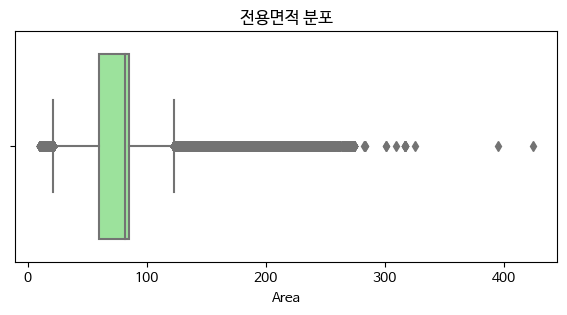

In [43]:
# ÎåÄÌëúÏ†ÅÏù∏ Ïó∞ÏÜçÌòï Î≥ÄÏàòÏù∏ ‚ÄúÏ†ÑÏö© Î©¥Ï†Å‚Äù Î≥ÄÏàò Í¥ÄÎ†®Ìïú Î∂ÑÌè¨Î•º Î®ºÏ†Ä ÏÇ¥Ìé¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = 'Ï†ÑÏö©Î©¥Ï†Å', color='lightgreen')
plt.title('Ï†ÑÏö©Î©¥Ï†Å Î∂ÑÌè¨')
plt.xlabel('Area')
plt.show()

In [44]:
# Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑÏùò shapeÏùÄ ÏïÑÎûòÏôÄ Í∞ôÏäµÎãàÎã§. ÏïΩ 10ÎßåÍ∞úÏùò Îç∞Ïù¥ÌÑ∞Í∞Ä Ï†úÍ±∞Îêú Î™®ÏäµÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.
print(concat_select.shape)

(1128094, 15)


In [45]:
concat_select['is_test'].value_counts()     # ÎòêÌïú, train dataÎßå Ï†úÍ±∞ÎêòÏóàÏäµÎãàÎã§.

is_test
0    1118822
1       9272
Name: count, dtype: int64

In [46]:
concat_select['ÏãúÍµ∞Íµ¨'].map(lambda x : x.split()[2])

0       Í∞úÌè¨Îèô
1       Í∞úÌè¨Îèô
2       Í∞úÌè¨Îèô
3       Í∞úÌè¨Îèô
4       Í∞úÌè¨Îèô
       ... 
9267    Ïã†ÎÇ¥Îèô
9268    Ïã†ÎÇ¥Îèô
9269    Ïã†ÎÇ¥Îèô
9270    Ïã†ÎÇ¥Îèô
9271    Ïã†ÎÇ¥Îèô
Name: ÏãúÍµ∞Íµ¨, Length: 1128094, dtype: object

In [47]:
concat_select['Í≥ÑÏïΩÎÖÑÏõî'].astype('str').map(lambda x : x[:4])

0       2017
1       2017
2       2017
3       2018
4       2018
        ... 
9267    2023
9268    2023
9269    2023
9270    2023
9271    2023
Name: Í≥ÑÏïΩÎÖÑÏõî, Length: 1128094, dtype: object

In [48]:
# ÏãúÍµ∞Íµ¨, ÎÖÑÏõî Îì± Î∂ÑÌï†Ìï† Ïàò ÏûàÎäî Î≥ÄÏàòÎì§ÏùÄ ÏÑ∏Î∂ÄÏÇ¨Ìï≠ Í≥†Î†§Î•º Ïö©Ïù¥ÌïòÍ≤å ÌïòÍ∏∞ ÏúÑÌï¥ Î™®Îëê Î∂ÑÌï†Ìï¥ Ï£ºÍ≤†ÏäµÎãàÎã§.
concat_select['Íµ¨'] = concat_select['ÏãúÍµ∞Íµ¨'].map(lambda x : x.split()[1])
concat_select['Îèô'] = concat_select['ÏãúÍµ∞Íµ¨'].map(lambda x : x.split()[2])
del concat_select['ÏãúÍµ∞Íµ¨']

concat_select['Í≥ÑÏïΩÎÖÑ'] = concat_select['Í≥ÑÏïΩÎÖÑÏõî'].astype('str').map(lambda x : x[:4])
concat_select['Í≥ÑÏïΩÏõî'] = concat_select['Í≥ÑÏïΩÎÖÑÏõî'].astype('str').map(lambda x : x[4:])
del concat_select['Í≥ÑÏïΩÎÖÑÏõî']

In [49]:
concat_select.columns

Index(['Î≤àÏßÄ', 'Ï∏µ', 'is_test', 'Ï¢åÌëúY', 'ÏïÑÌååÌä∏Î™Ö', 'Í≥ÑÏïΩÏùº', 'Î≥∏Î≤à', 'Î∂ÄÎ≤à', 'Ï¢åÌëúX', 'ÎèÑÎ°úÎ™Ö',
       'Í±¥Ï∂ïÎÖÑÎèÑ', 'target', 'Ï†ÑÏö©Î©¥Ï†Å', 'Íµ¨', 'Îèô', 'Í≥ÑÏïΩÎÖÑ', 'Í≥ÑÏïΩÏõî'],
      dtype='object')

In [50]:
concat_select.shape

(1128094, 17)

In [51]:
# ================================================================= #
# ‚ú® 1. [ÏàúÏÑú Î≥ÄÍ≤Ω] ÏãúÏ∞®(Lag) Ï†ÅÏö© ÌååÏÉùÎ≥ÄÏàò ÏÉùÏÑ± Î®ºÏ†Ä Ïã§Ìñâ
# ================================================================= #


concat_select['Í≥ÑÏïΩÎÖÑÏõî'] = concat_select['Í≥ÑÏïΩÎÖÑ'] + concat_select['Í≥ÑÏïΩÏõî'].str.zfill(2)

dt_rate['Íµ≠Í≥†Ï±Ñ_2y_lag'] = dt_rate['Íµ≠Í≥†Ï±Ñ'].shift(24)

# --- 1-3. ÏãúÏ∞® Ï†ÅÏö©Îêú Îç∞Ïù¥ÌÑ∞Î•º Î≥∏ Îç∞Ïù¥ÌÑ∞Ïóê Î≥ëÌï© ---
dt_rate_lagged = dt_rate[['Ïó∞Ïõî', 'Íµ≠Í≥†Ï±Ñ_2y_lag']]
concat_select = pd.merge(concat_select, dt_rate_lagged, left_on='Í≥ÑÏïΩÎÖÑÏõî', right_on='Ïó∞Ïõî', how='left')

# --- 1-4. ÌõÑÏ≤òÎ¶¨ ---
concat_select = concat_select.drop(columns=['Ïó∞Ïõî', 'Í≥ÑÏïΩÎÖÑÏõî'])
concat_select['Íµ≠Í≥†Ï±Ñ_2y_lag'] = concat_select['Íµ≠Í≥†Ï±Ñ_2y_lag'].fillna(method='ffill').fillna(method='bfill')

print("\n‚úÖ 'Íµ≠Í≥†Ï±Ñ_2y_lag' Ïª¨Îüº Ï∂îÍ∞Ä ÏôÑÎ£å")


# ================================================================= #
# ‚ú® 2. [ÏàúÏÑú Î≥ÄÍ≤Ω] Î∂àÌïÑÏöîÌïú Î≥ÄÏàò Ï†úÍ±∞ Î∞è ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±
# ================================================================= #
# Î™®Îì† ÌååÏÉù Î≥ÄÏàò ÏÉùÏÑ±Ïù¥ ÎÅùÎÇú ÌõÑ, Ïù¥ ÏãúÏ†êÏóêÏÑú Î∂àÌïÑÏöîÌïú Î≥ÄÏàòÎ•º Ï†úÍ±∞Ìï©ÎãàÎã§.
del_features = ['Î∂ÄÎ≤à', 'Í≥ÑÏïΩÏùº', 'Í≥ÑÏïΩÏõî']
concat_select_ft = concat_select.drop(del_features, axis=1)

print("\n‚úÖ Î∂àÌïÑÏöîÌïú Î≥ÄÏàò Ï†úÍ±∞ ÏôÑÎ£å")
print("ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ÏÖã Ïª¨Îüº ÌôïÏù∏:", concat_select_ft.columns)


‚úÖ 'Íµ≠Í≥†Ï±Ñ_2y_lag' Ïª¨Îüº Ï∂îÍ∞Ä ÏôÑÎ£å

‚úÖ Î∂àÌïÑÏöîÌïú Î≥ÄÏàò Ï†úÍ±∞ ÏôÑÎ£å
ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ÏÖã Ïª¨Îüº ÌôïÏù∏: Index(['Î≤àÏßÄ', 'Ï∏µ', 'is_test', 'Ï¢åÌëúY', 'ÏïÑÌååÌä∏Î™Ö', 'Î≥∏Î≤à', 'Ï¢åÌëúX', 'ÎèÑÎ°úÎ™Ö', 'Í±¥Ï∂ïÎÖÑÎèÑ',
       'target', 'Ï†ÑÏö©Î©¥Ï†Å', 'Íµ¨', 'Îèô', 'Í≥ÑÏïΩÎÖÑ', 'Íµ≠Í≥†Ï±Ñ_2y_lag'],
      dtype='object')


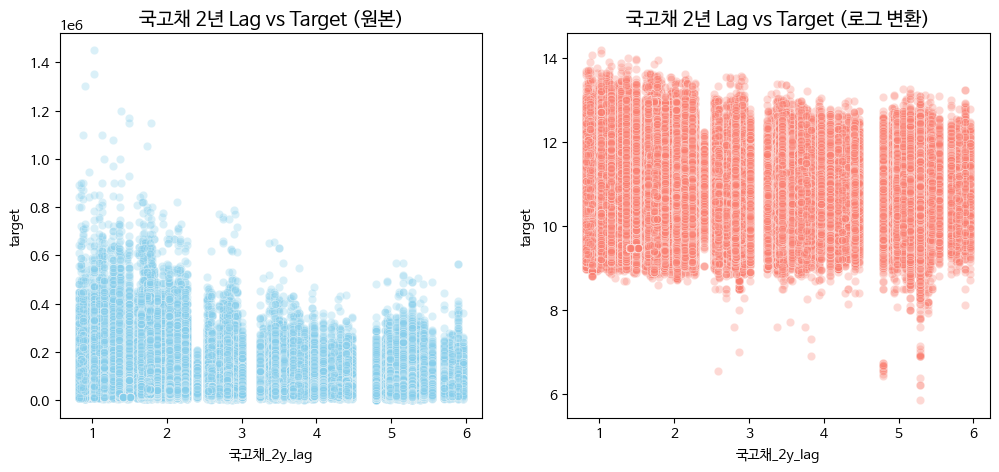

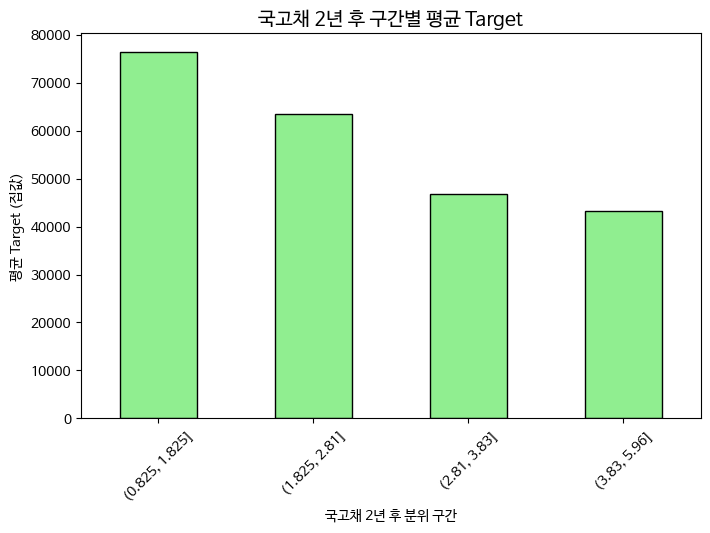

üìä Íµ≠Í≥†Ï±Ñ 2ÎÖÑ lag Î∂ÑÏúÑÏàò:
 0.25    1.825
0.50    2.810
0.75    3.830
Name: Íµ≠Í≥†Ï±Ñ_2y_lag, dtype: float64


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =========================
# 1. Íµ≠Í≥†Ï±Ñ lag vs Target (ÏÇ∞Ï†êÎèÑ)
# =========================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.scatterplot(data=concat_select_ft, x="Íµ≠Í≥†Ï±Ñ_2y_lag", y="target", alpha=0.3, color="skyblue")
plt.title("Íµ≠Í≥†Ï±Ñ 2ÎÖÑ Lag vs Target (ÏõêÎ≥∏)", fontsize=14)

plt.subplot(1,2,2)
sns.scatterplot(data=concat_select_ft, x="Íµ≠Í≥†Ï±Ñ_2y_lag", y=np.log1p(concat_select_ft['target']), alpha=0.3, color="salmon")
plt.title("Íµ≠Í≥†Ï±Ñ 2ÎÖÑ Lag vs Target (Î°úÍ∑∏ Î≥ÄÌôò)", fontsize=14)

plt.show()

# =========================
# 2. Íµ¨Í∞Ñ ÎÇòÎàî (4Î∂ÑÏúÑ)
# =========================
num_bins = 4
bins = pd.qcut(concat_select_ft["Íµ≠Í≥†Ï±Ñ_2y_lag"], q=num_bins, duplicates="drop")
bin_categories = bins.cat.categories

concat_select_ft["Í∏àÎ¶¨_bin"] = pd.cut(concat_select_ft["Íµ≠Í≥†Ï±Ñ_2y_lag"], bins=bin_categories)

# Íµ¨Í∞ÑÎ≥Ñ ÌèâÍ∑† Target Í≥ÑÏÇ∞
bin_target_mean = concat_select_ft.groupby("Í∏àÎ¶¨_bin")["target"].mean()

# =========================
# 3. Íµ¨Í∞ÑÎ≥Ñ ÌèâÍ∑† Target ÏãúÍ∞ÅÌôî
# =========================
plt.figure(figsize=(8,5))
bin_target_mean.plot(kind="bar", color="lightgreen", edgecolor="black")
plt.title("Íµ≠Í≥†Ï±Ñ 2ÎÖÑ ÌõÑ Íµ¨Í∞ÑÎ≥Ñ ÌèâÍ∑† Target", fontsize=14)
plt.xlabel("Íµ≠Í≥†Ï±Ñ 2ÎÖÑ ÌõÑ Î∂ÑÏúÑ Íµ¨Í∞Ñ")
plt.ylabel("ÌèâÍ∑† Target (ÏßëÍ∞í)")
plt.xticks(rotation=45)
plt.show()

# =========================
# 4. Î∂ÑÏúÑÏàò Í∞í Ï∂úÎ†•
# =========================
quantiles = concat_select_ft["Íµ≠Í≥†Ï±Ñ_2y_lag"].quantile([0.25, 0.5, 0.75])
print("üìä Íµ≠Í≥†Ï±Ñ 2ÎÖÑ lag Î∂ÑÏúÑÏàò:\n", quantiles)


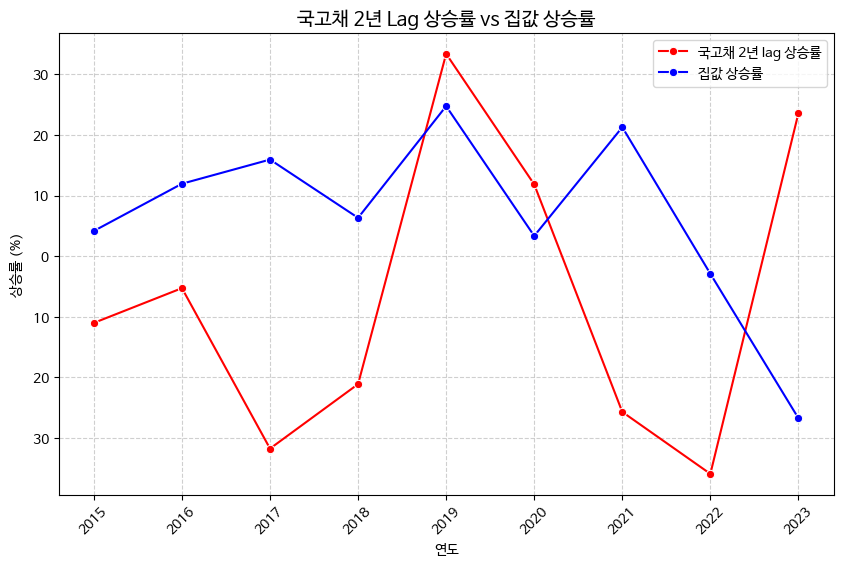

In [53]:
# =========================
# 1. Ïó∞ÎèÑÎ≥Ñ ÌèâÍ∑† ÏßëÍ∞í(Target)Í≥º ÌèâÍ∑† Íµ≠Í≥†Ï±Ñ_2y_lag Í≥ÑÏÇ∞
# =========================
yearly_mean = concat_select_ft.groupby("Í≥ÑÏïΩÎÖÑ")[["target", "Íµ≠Í≥†Ï±Ñ_2y_lag"]].mean().reset_index()

# Í≥ÑÏïΩÎÖÑÏùÑ Ï†ïÏàòÌòïÏúºÎ°ú Î≥ÄÌôò (Î¨∏ÏûêÏó¥Ïù¥Î©¥ Ï†ïÎ†¨Ïù¥ Íº¨Ïùº Ïàò ÏûàÏùå)
yearly_mean["Í≥ÑÏïΩÎÖÑ"] = yearly_mean["Í≥ÑÏïΩÎÖÑ"].astype(int)

# =========================
# 2. Ï†ÑÎÖÑ ÎåÄÎπÑ ÏÉÅÏäπÎ•†(%) Í≥ÑÏÇ∞
# =========================
yearly_mean["Íµ≠Í≥†Ï±Ñ_ÏÉÅÏäπÎ•†(%)"] = yearly_mean["Íµ≠Í≥†Ï±Ñ_2y_lag"].pct_change() * 100
yearly_mean["ÏßëÍ∞í_ÏÉÅÏäπÎ•†(%)"] = yearly_mean["target"].pct_change() * 100

# Ï≤´ Ìï¥ NaN Ï†úÍ±∞
yearly_mean = yearly_mean.dropna()

# =========================
# 3. 2015ÎÖÑ Ïù¥ÌõÑÎßå ÌïÑÌÑ∞ÎßÅ
# =========================
yearly_mean = yearly_mean[yearly_mean["Í≥ÑÏïΩÎÖÑ"] >= 2015]

# =========================
# 4. ÏãúÍ∞ÅÌôî
# =========================
plt.figure(figsize=(10,6))
sns.lineplot(data=yearly_mean, x="Í≥ÑÏïΩÎÖÑ", y="Íµ≠Í≥†Ï±Ñ_ÏÉÅÏäπÎ•†(%)", label="Íµ≠Í≥†Ï±Ñ 2ÎÖÑ lag ÏÉÅÏäπÎ•†", marker="o", color="red")
sns.lineplot(data=yearly_mean, x="Í≥ÑÏïΩÎÖÑ", y="ÏßëÍ∞í_ÏÉÅÏäπÎ•†(%)", label="ÏßëÍ∞í ÏÉÅÏäπÎ•†", marker="o", color="blue")

plt.title("Íµ≠Í≥†Ï±Ñ 2ÎÖÑ Lag ÏÉÅÏäπÎ•† vs ÏßëÍ∞í ÏÉÅÏäπÎ•†", fontsize=14)
plt.xlabel("Ïó∞ÎèÑ")
plt.ylabel("ÏÉÅÏäπÎ•† (%)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [54]:
del_features = ['Î∂ÄÎ≤à', 'Í≥ÑÏïΩÏùº', 'Í≥ÑÏïΩÏõî']
concat_select_ft = concat_select.drop(del_features, axis=1)

print("\n‚úÖ Î∂àÌïÑÏöîÌïú Î≥ÄÏàò Ï†úÍ±∞ ÏôÑÎ£å")
print("ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ÏÖã Ïª¨Îüº ÌôïÏù∏:", concat_select_ft.columns)



‚úÖ Î∂àÌïÑÏöîÌïú Î≥ÄÏàò Ï†úÍ±∞ ÏôÑÎ£å
ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ÏÖã Ïª¨Îüº ÌôïÏù∏: Index(['Î≤àÏßÄ', 'Ï∏µ', 'is_test', 'Ï¢åÌëúY', 'ÏïÑÌååÌä∏Î™Ö', 'Î≥∏Î≤à', 'Ï¢åÌëúX', 'ÎèÑÎ°úÎ™Ö', 'Í±¥Ï∂ïÎÖÑÎèÑ',
       'target', 'Ï†ÑÏö©Î©¥Ï†Å', 'Íµ¨', 'Îèô', 'Í≥ÑÏïΩÎÖÑ', 'Íµ≠Í≥†Ï±Ñ_2y_lag'],
      dtype='object')


In [55]:
concat_select_ft.columns

Index(['Î≤àÏßÄ', 'Ï∏µ', 'is_test', 'Ï¢åÌëúY', 'ÏïÑÌååÌä∏Î™Ö', 'Î≥∏Î≤à', 'Ï¢åÌëúX', 'ÎèÑÎ°úÎ™Ö', 'Í±¥Ï∂ïÎÖÑÎèÑ',
       'target', 'Ï†ÑÏö©Î©¥Ï†Å', 'Íµ¨', 'Îèô', 'Í≥ÑÏïΩÎÖÑ', 'Íµ≠Í≥†Ï±Ñ_2y_lag'],
      dtype='object')

In [56]:
gu_list = list(concat_select_ft['Íµ¨'].unique())
gu_list

['Í∞ïÎÇ®Íµ¨',
 'Í∞ïÎèôÍµ¨',
 'Í∞ïÎ∂ÅÍµ¨',
 'Í∞ïÏÑúÍµ¨',
 'Í¥ÄÏïÖÍµ¨',
 'Í¥ëÏßÑÍµ¨',
 'Íµ¨Î°úÍµ¨',
 'Í∏àÏ≤úÍµ¨',
 'ÎÖ∏ÏõêÍµ¨',
 'ÎèÑÎ¥âÍµ¨',
 'ÎèôÎåÄÎ¨∏Íµ¨',
 'ÎèôÏûëÍµ¨',
 'ÎßàÌè¨Íµ¨',
 'ÏÑúÎåÄÎ¨∏Íµ¨',
 'ÏÑúÏ¥àÍµ¨',
 'ÏÑ±ÎèôÍµ¨',
 'ÏÑ±Î∂ÅÍµ¨',
 'ÏÜ°ÌååÍµ¨',
 'ÏñëÏ≤úÍµ¨',
 'ÏòÅÎì±Ìè¨Íµ¨',
 'Ïö©ÏÇ∞Íµ¨',
 'ÏùÄÌèâÍµ¨',
 'Ï¢ÖÎ°úÍµ¨',
 'Ï§ëÍµ¨',
 'Ï§ëÎûëÍµ¨']

In [57]:
concat_select_ft.groupby('Íµ¨')['target'].count()

Íµ¨
Í∞ïÎÇ®Íµ¨      69656
Í∞ïÎèôÍµ¨      62425
Í∞ïÎ∂ÅÍµ¨      22137
Í∞ïÏÑúÍµ¨      67041
Í¥ÄÏïÖÍµ¨      36243
Í¥ëÏßÑÍµ¨      22252
Íµ¨Î°úÍµ¨      57983
Í∏àÏ≤úÍµ¨      19738
ÎÖ∏ÏõêÍµ¨     115837
ÎèÑÎ¥âÍµ¨      52872
ÎèôÎåÄÎ¨∏Íµ¨     40068
ÎèôÏûëÍµ¨      40867
ÎßàÌè¨Íµ¨      40810
ÏÑúÎåÄÎ¨∏Íµ¨     33272
ÏÑúÏ¥àÍµ¨      53553
ÏÑ±ÎèôÍµ¨      39831
ÏÑ±Î∂ÅÍµ¨      57160
ÏÜ°ÌååÍµ¨      74444
ÏñëÏ≤úÍµ¨      54441
ÏòÅÎì±Ìè¨Íµ¨     48097
Ïö©ÏÇ∞Íµ¨      20682
ÏùÄÌèâÍµ¨      38664
Ï¢ÖÎ°úÍµ¨       9184
Ï§ëÍµ¨       13534
Ï§ëÎûëÍµ¨      37303
Name: target, dtype: int64

In [58]:
gangnam_data = concat_select.loc[concat_select['Íµ¨'] == 'Í∞ïÎÇ®Íµ¨']

# plt.figure(figsize=(15,12))
# plt.bar(gangnam_data['Îèô'], gangnam_data['target'])
# plt.xlabel('Íµ¨')
# plt.ylabel('price')
# plt.show()

## 5. Model Training

In [60]:
# Ïù¥Ï†ú Îã§Ïãú trainÍ≥º test datasetÏùÑ Î∂ÑÌï†Ìï¥Ï§çÎãàÎã§. ÏúÑÏóêÏÑú Ï†úÏûëÌï¥ ÎÜìÏïòÎçò is_test ÏπºÎüºÏùÑ Ïù¥Ïö©Ìï©ÎãàÎã§.
dt_train = concat_select_ft.query('is_test==0')
dt_test = concat_select_ft.query('is_test==1')

# Ïù¥Ï†ú is_test ÏπºÎüºÏùÄ dropÌï¥Ï§çÎãàÎã§.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1118822, 14) (9272, 14)


#### Ï†ÑÏö©Î©¥Ï†Å Î≥ÄÏàò

In [61]:
num_bins = 4
bins = pd.qcut(dt_train['Ï†ÑÏö©Î©¥Ï†Å'], q=num_bins, duplicates='drop')
bin_categories = bins.cat.categories

dt_train['Ï†ÑÏö©Î©¥Ï†Å_bin'] = pd.cut(dt_train['Ï†ÑÏö©Î©¥Ï†Å'], bins=bin_categories)
dt_test['Ï†ÑÏö©Î©¥Ï†Å_bin'] = pd.cut(dt_test['Ï†ÑÏö©Î©¥Ï†Å'], bins=bin_categories)

bin_target_mean = dt_train.groupby('Ï†ÑÏö©Î©¥Ï†Å_bin')['target'].mean()
dt_train['Ï†ÑÏö©Î©¥Ï†Å_target_mean'] = dt_train['Ï†ÑÏö©Î©¥Ï†Å_bin'].map(bin_target_mean)
dt_test['Ï†ÑÏö©Î©¥Ï†Å_target_mean'] = dt_test['Ï†ÑÏö©Î©¥Ï†Å_bin'].map(bin_target_mean)

In [62]:
# dt_testÏùò targetÏùÄ ÏùºÎã® 0ÏúºÎ°ú ÏûÑÏùòÎ°ú Ï±ÑÏõåÏ£ºÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
dt_test['target'] = 0

#### Î≤îÏ£ºÌòï Ïù∏ÏΩîÎî©

In [63]:
# ÌååÏÉùÎ≥ÄÏàò Ï†úÏûëÏúºÎ°ú Ï∂îÍ∞ÄÎêú Î≥ÄÏàòÎì§Ïù¥ Ï°¥Ïû¨ÌïòÍ∏∞Ïóê, Îã§ÏãúÌïúÎ≤à Ïó∞ÏÜçÌòïÍ≥º Î≤îÏ£ºÌòï ÏπºÎüºÏùÑ Î∂ÑÎ¶¨Ìï¥Ï£ºÍ≤†ÏäµÎãàÎã§.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

categorical_columns_v2.remove('Íµ¨')
print("Ïó∞ÏÜçÌòï Î≥ÄÏàò:", continuous_columns_v2)
print("Î≤îÏ£ºÌòï Î≥ÄÏàò:", categorical_columns_v2)

Ïó∞ÏÜçÌòï Î≥ÄÏàò: ['Ï∏µ', 'Ï¢åÌëúY', 'Ï¢åÌëúX', 'Í±¥Ï∂ïÎÖÑÎèÑ', 'target', 'Ï†ÑÏö©Î©¥Ï†Å', 'Íµ≠Í≥†Ï±Ñ_2y_lag']
Î≤îÏ£ºÌòï Î≥ÄÏàò: ['Î≤àÏßÄ', 'ÏïÑÌååÌä∏Î™Ö', 'Î≥∏Î≤à', 'ÎèÑÎ°úÎ™Ö', 'Îèô', 'Í≥ÑÏïΩÎÖÑ', 'Ï†ÑÏö©Î©¥Ï†Å_bin', 'Ï†ÑÏö©Î©¥Ï†Å_target_mean']


In [64]:
# ÏïÑÎûòÏóêÏÑú Î≤îÏ£ºÌòï Î≥ÄÏàòÎì§ÏùÑ ÎåÄÏÉÅÏúºÎ°ú Î†àÏù¥Î∏îÏù∏ÏΩîÎî©ÏùÑ ÏßÑÌñâÌï¥ Ï£ºÍ≤†ÏäµÎãàÎã§.

# Í∞Å Î≥ÄÏàòÏóê ÎåÄÌïú LabelEncoderÎ•º Ï†ÄÏû•Ìï† ÎîïÏÖîÎÑàÎ¶¨
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-EncodingÏùÑ fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # ÎÇòÏ§ëÏóê ÌõÑÏ≤òÎ¶¨Î•º ÏúÑÌï¥ Î†àÏù¥Î∏îÏù∏ÏΩîÎçîÎ•º Ï†ÄÏû•Ìï¥Ï£ºÍ≤†ÏäµÎãàÎã§.

    # Test Îç∞Ïù¥ÌÑ∞ÏóêÎßå Ï°¥Ïû¨ÌïòÎäî ÏÉàÎ°ú Ï∂úÌòÑÌïú Îç∞Ïù¥ÌÑ∞Î•º Ïã†Í∑ú ÌÅ¥ÎûòÏä§Î°ú Ï∂îÍ∞ÄÌï¥Ï§çÎãàÎã§.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label Îç∞Ïù¥ÌÑ∞Ïù∏ Í≤ΩÏö∞
        lbl.classes_ = np.append(lbl.classes_, label) # ÎØ∏Ï≤òÎ¶¨ Ïãú ValueErrorÎ∞úÏÉùÌïòÎãà Ï£ºÏùòÌïòÏÑ∏Ïöî!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8/8 [00:02<00:00,  3.11it/s]


In [65]:
# one-hot encoding
features = ['Íµ¨']

dt_train = pd.get_dummies(dt_train, columns=features)

dt_test = pd.get_dummies(dt_test, columns=features)

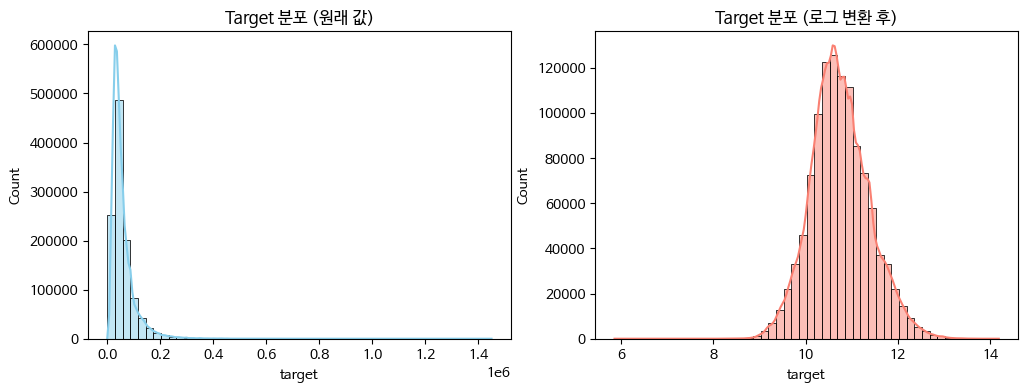

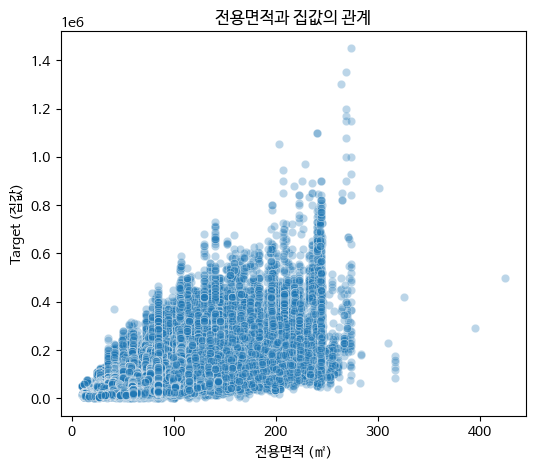

üìä Ï†ÑÏö©Î©¥Ï†Å ‚Üî Target ÏÉÅÍ¥ÄÍ≥ÑÏàò (ÌîºÏñ¥Ïä®): 0.577
üìä Ï†ÑÏö©Î©¥Ï†Å ‚Üî Target ÏÉÅÍ¥ÄÍ≥ÑÏàò (Ïä§ÌîºÏñ¥Îßå): 0.598


In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =========================
# 1. ÌÉÄÍ≤üÍ∞í Î∂ÑÌè¨ ÌôïÏù∏
# =========================
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(dt_train['target'], bins=50, kde=True, color="skyblue")
plt.title("Target Î∂ÑÌè¨ (ÏõêÎûò Í∞í)")

plt.subplot(1,2,2)
sns.histplot(np.log1p(dt_train['target']), bins=50, kde=True, color="salmon")
plt.title("Target Î∂ÑÌè¨ (Î°úÍ∑∏ Î≥ÄÌôò ÌõÑ)")

plt.show()

# =========================
# 2. Ï†ÑÏö©Î©¥Ï†Å vs Target Í¥ÄÍ≥Ñ
# =========================
plt.figure(figsize=(6,5))
sns.scatterplot(data=dt_train, x="Ï†ÑÏö©Î©¥Ï†Å", y="target", alpha=0.3)
plt.title("Ï†ÑÏö©Î©¥Ï†ÅÍ≥º ÏßëÍ∞íÏùò Í¥ÄÍ≥Ñ")
plt.xlabel("Ï†ÑÏö©Î©¥Ï†Å („é°)")
plt.ylabel("Target (ÏßëÍ∞í)")
plt.show()

# =========================
# 3. ÏÉÅÍ¥ÄÍ≥ÑÏàò Í≥ÑÏÇ∞
# =========================
corr_pearson = dt_train[['Ï†ÑÏö©Î©¥Ï†Å','target']].corr(method='pearson').iloc[0,1]
corr_spearman = dt_train[['Ï†ÑÏö©Î©¥Ï†Å','target']].corr(method='spearman').iloc[0,1]

print(f"üìä Ï†ÑÏö©Î©¥Ï†Å ‚Üî Target ÏÉÅÍ¥ÄÍ≥ÑÏàò (ÌîºÏñ¥Ïä®): {corr_pearson:.3f}")
print(f"üìä Ï†ÑÏö©Î©¥Ï†Å ‚Üî Target ÏÉÅÍ¥ÄÍ≥ÑÏàò (Ïä§ÌîºÏñ¥Îßå): {corr_spearman:.3f}")


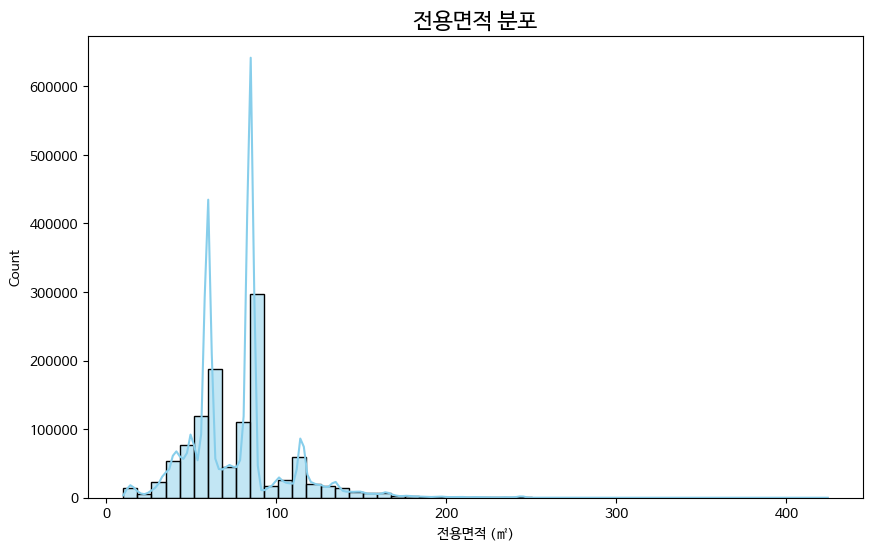

Ï†ÑÏö©Î©¥Ï†Å Ï£ºÏöî Î∂ÑÏúÑÏàò:
 0.25     59.65
0.50     81.88
0.75     84.96
0.90    114.88
0.95    131.40
Name: Ï†ÑÏö©Î©¥Ï†Å, dtype: float64


In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(dt_train['Ï†ÑÏö©Î©¥Ï†Å'], bins=50, kde=True, color="skyblue", edgecolor="black")
plt.title("Ï†ÑÏö©Î©¥Ï†Å Î∂ÑÌè¨", fontsize=16)
plt.xlabel("Ï†ÑÏö©Î©¥Ï†Å („é°)")
plt.ylabel("Count")
plt.show()

# ÏÇ¨Î∂ÑÏúÑÏàò ÌôïÏù∏
quantiles = dt_train['Ï†ÑÏö©Î©¥Ï†Å'].quantile([0.25, 0.5, 0.75, 0.9, 0.95])
print("Ï†ÑÏö©Î©¥Ï†Å Ï£ºÏöî Î∂ÑÏúÑÏàò:\n", quantiles)


In [68]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test datasetÏùò shapeÏù¥ Í∞ôÏùÄÏßÄ ÌôïÏù∏Ìï¥Ï£ºÍ≤†ÏäµÎãàÎã§.

# Î™®Îç∏ Íµ¨Î∂Ñ

#### LGBM MODEL

In [75]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# ---------------------------
# TimeSeriesSplit Ï†ïÏùò
# ---------------------------
kf = TimeSeriesSplit(n_splits=5)

# TargetÍ≥º ÎèÖÎ¶ΩÎ≥ÄÏàò Î∂ÑÎ¶¨
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# float Î≥ÄÌôò
X_train = X_train.astype(float)
X_test = dt_test.drop(['target'], axis=1).astype(float)

# ---------------------------
# ÌïôÏäµ ÏßÑÌñâ
# ---------------------------
fold_save_files = []
cv_results = []

for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(X_train, y_train)):
    print(f"\n-------- {fold_idx}Î≤àÏß∏ fold ÌïôÏäµ ÏãúÏûë --------")

    # indexÎ°ú Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = y_train.iloc[train_idx]
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = y_train.iloc[valid_idx]

    # CSV Ï†ÄÏû• ÌõÑ numpy Î°úÎìú
    X_train_fold.to_csv(f'X_train_fold_{fold_idx}.csv', index=False)
    Y_train_fold.to_csv(f'Y_train_fold_{fold_idx}.csv', index=False, header=True)
    X_valid_fold.to_csv(f'X_valid_fold_{fold_idx}.csv', index=False)
    Y_valid_fold.to_csv(f'Y_valid_fold_{fold_idx}.csv', index=False, header=True)

    X_train_fold_np = np.loadtxt(f'X_train_fold_{fold_idx}.csv', delimiter=',', skiprows=1, dtype=np.float32)
    Y_train_fold_np = np.loadtxt(f'Y_train_fold_{fold_idx}.csv', delimiter=',', skiprows=1, dtype=np.float32)
    X_valid_fold_np = np.loadtxt(f'X_valid_fold_{fold_idx}.csv', delimiter=',', skiprows=1, dtype=np.float32)
    Y_valid_fold_np = np.loadtxt(f'Y_valid_fold_{fold_idx}.csv', delimiter=',', skiprows=1, dtype=np.float32)

    if Y_train_fold_np.ndim > 1: 
        Y_train_fold_np = Y_train_fold_np.ravel()
    if Y_valid_fold_np.ndim > 1: 
        Y_valid_fold_np = Y_valid_fold_np.ravel()

    # Î™®Îç∏ ÌïôÏäµ
    gbm = lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        num_leaves=15,
        max_depth=10,
        min_child_samples=50,
        min_child_weight=1e-3,
        feature_fraction=0.6,
        bagging_fraction=0.6,
        bagging_freq=1,
        lambda_l1=2.0,   # L1 Í∑úÏ†ú
        lambda_l2=5.0,   # L2 Í∑úÏ†ú
        random_state=42,
        n_jobs=-1
    )
    gbm.fit(
        X_train_fold_np, Y_train_fold_np,
        eval_set=[(X_valid_fold_np, Y_valid_fold_np)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=100)]
    )

    # ÏòàÏ∏°
    y_train_pred = gbm.predict(X_train_fold_np, num_iteration=gbm.best_iteration_)
    y_valid_pred = gbm.predict(X_valid_fold_np, num_iteration=gbm.best_iteration_)

    # RMSE Í≥ÑÏÇ∞
    rmse_train = np.sqrt(mean_squared_error(Y_train_fold_np, y_train_pred))
    rmse_valid = np.sqrt(mean_squared_error(Y_valid_fold_np, y_valid_pred))

    cv_results.append({
        "fold": fold_idx,
        "train_RMSE": rmse_train,
        "valid_RMSE": rmse_valid
    })

    print(f"‚úÖ Fold {fold_idx} | Train RMSE: {rmse_train:,.0f} | Valid RMSE: {rmse_valid:,.0f}")

    # Î™®Îç∏ Ï†ÄÏû•
    file_name = f"timeseries_fold{fold_idx}_gbm.pkl"
    joblib.dump(gbm, file_name)
    fold_save_files.append(file_name)

# ---------------------------
# ÍµêÏ∞®Í≤ÄÏ¶ù Í≤∞Í≥º ÏöîÏïΩ
# ---------------------------
cv_df = pd.DataFrame(cv_results)
print("\n======== ÍµêÏ∞®Í≤ÄÏ¶ù Í≤∞Í≥º ÏöîÏïΩ ========")
print(cv_df)

print("\nÌèâÍ∑† Train RMSE:", cv_df["train_RMSE"].mean())
print("ÌèâÍ∑† Valid RMSE:", cv_df["valid_RMSE"].mean())
print("ÏµúÏ†Å(Í∞ÄÏû• ÎÇÆÏùÄ) Valid RMSE:", cv_df["valid_RMSE"].min())



-------- 0Î≤àÏß∏ fold ÌïôÏäµ ÏãúÏûë --------


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=2.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] lambda_l1 is set=2.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0
[Ligh

#### RF MODEL

In [77]:
print("\nüå≥ RandomForest ÍµêÏ∞®Í≤ÄÏ¶ù ÏãúÏûë\n")
rf_results, rf_files = [], []

for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(X_train, y_train)):
    print(f"\n======== [RF] Fold-{fold_idx} ========")

    # Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
    X_train_fold = X_train.iloc[train_idx, :].copy()
    Y_train_fold = y_train.iloc[train_idx]
    X_valid_fold = X_train.iloc[valid_idx, :].copy()
    Y_valid_fold = y_train.iloc[valid_idx]

    # numpy Î≥ÄÌôò
    X_train_fold_np, Y_train_fold_np = X_train_fold.to_numpy(), Y_train_fold.to_numpy()
    X_valid_fold_np, Y_valid_fold_np = X_valid_fold.to_numpy(), Y_valid_fold.to_numpy()

    # Î™®Îç∏ Ï†ïÏùò Î∞è ÌïôÏäµ
    # Î™®Îç∏ Ï†ïÏùò (Í∑úÏ†ú Ìö®Í≥º Ìè¨Ìï®)
    rf = RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_split=20,
        min_samples_leaf=10,
        max_features=0.5,
        max_samples=0.8,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train_fold_np, Y_train_fold_np
           )

    # ÏòàÏ∏°
    y_train_pred = rf.predict(X_train_fold_np)
    y_valid_pred = rf.predict(X_valid_fold_np)

    # RMSE
    rmse_train = np.sqrt(mean_squared_error(Y_train_fold_np, y_train_pred))
    rmse_valid = np.sqrt(mean_squared_error(Y_valid_fold_np, y_valid_pred))

    rf_results.append({"fold": fold_idx, "train_RMSE": rmse_train, "valid_RMSE": rmse_valid})
    print(f"‚úÖ Train RMSE: {rmse_train:,.0f} | Valid RMSE: {rmse_valid:,.0f}")

    # Î™®Îç∏ Ï†ÄÏû•
    file_name = f"rf_fold{fold_idx}.pkl"
    joblib.dump(rf, file_name)
    rf_files.append(file_name)

rf_df = pd.DataFrame(rf_results)
print("\nüìä RandomForest ÍµêÏ∞®Í≤ÄÏ¶ù Í≤∞Í≥º\n", rf_df)
print("ÌèâÍ∑† Valid RMSE:", rf_df["valid_RMSE"].mean())
print("ÏµúÏ†Å Valid RMSE:", rf_df["valid_RMSE"].min())



üå≥ RandomForest ÍµêÏ∞®Í≤ÄÏ¶ù ÏãúÏûë


======== [RF] Fold-0 ========
‚úÖ Train RMSE: 7,867 | Valid RMSE: 42,050

======== [RF] Fold-1 ========
‚úÖ Train RMSE: 11,337 | Valid RMSE: 20,142

======== [RF] Fold-2 ========
‚úÖ Train RMSE: 10,658 | Valid RMSE: 8,302

======== [RF] Fold-3 ========
‚úÖ Train RMSE: 9,575 | Valid RMSE: 7,777

======== [RF] Fold-4 ========
‚úÖ Train RMSE: 8,878 | Valid RMSE: 9,020

üìä RandomForest ÍµêÏ∞®Í≤ÄÏ¶ù Í≤∞Í≥º
    fold    train_RMSE    valid_RMSE
0     0   7866.958982  42050.109435
1     1  11337.213723  20142.393423
2     2  10657.621178   8302.397450
3     3   9575.268176   7776.897015
4     4   8878.060617   9019.913213
ÌèâÍ∑† Valid RMSE: 17458.34210725603
ÏµúÏ†Å Valid RMSE: 7776.897015251229


#### XGBoost MODEL

In [79]:
import xgboost as xgb

print("\nüå≥ XGBoost ÍµêÏ∞®Í≤ÄÏ¶ù ÏãúÏûë\n")
xgb_results, xgb_files = [], []

# TimeSeriesSplit Î£®ÌîÑÎäî Í∑∏ÎåÄÎ°ú ÏÇ¨Ïö©Ìï©ÎãàÎã§.
for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(X_train, y_train)):
    print(f"\n======== [XGB] Fold-{fold_idx} ========")

    # 1. Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† Î∞è numpy Î≥ÄÌôò (Í∏∞Ï°¥Í≥º ÎèôÏùº)
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = y_train.iloc[train_idx]
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = y_train.iloc[valid_idx]

    X_train_fold_np, Y_train_fold_np = X_train_fold.to_numpy(), Y_train_fold.to_numpy()
    X_valid_fold_np, Y_valid_fold_np = X_valid_fold.to_numpy(), Y_valid_fold.to_numpy()

    # 2. XGBoost Ï†ÑÏö© Îç∞Ïù¥ÌÑ∞ ÌòïÏãù(DMatrix)ÏúºÎ°ú Î≥ÄÌôò
    dtrain = xgb.DMatrix(X_train_fold_np, label=Y_train_fold_np, feature_names=list(X_train.columns))
    dvalid = xgb.DMatrix(X_valid_fold_np, label=Y_valid_fold_np, feature_names=list(X_train.columns))


    # 3. Î™®Îç∏ ÌååÎùºÎØ∏ÌÑ∞ Ï†ïÏùò (RandomForest Í∑úÏ†ú Î∞©Ïãù Ï∞∏Í≥†)
    # RandomForestÏùò Í∑úÏ†ú ÌååÎùºÎØ∏ÌÑ∞Î•º XGBoostÏóê ÎßûÍ≤å Î≥ÄÌôòÌñàÏäµÎãàÎã§.
    params = {
        'objective': 'reg:squarederror', # ÌöåÍ∑Ä Î¨∏Ï†ú Ï†ïÏùò
        'eval_metric': 'rmse',           # ÌèâÍ∞Ä ÏßÄÌëú
        'eta': 0.02,                     # ÌïôÏäµÎ•† (learning_rate)
        'max_depth': 7,                 # Ìä∏Î¶¨ ÏµúÎåÄ ÍπäÏù¥ (RFÏùò max_depth)
        'min_child_weight': 10,          # Î¶¨ÌîÑ ÎÖ∏ÎìúÏùò ÏµúÏÜå Îç∞Ïù¥ÌÑ∞ Ïàò (RFÏùò min_samples_leaf)
        'subsample': 0.8,                # Îç∞Ïù¥ÌÑ∞ ÏÉòÌîåÎßÅ ÎπÑÏú® (RFÏùò max_samples)
        'colsample_bytree': 0.8,         # ÌîºÏ≤ò(Ïª¨Îüº) ÏÉòÌîåÎßÅ ÎπÑÏú® (RFÏùò max_featuresÏôÄ Ïú†ÏÇ¨)
        'gamma': 0.1,                    # <-- Í∑úÏ†ú Ï∂îÍ∞Ä
        'lambda': 2,                     # <-- L2 Í∑úÏ†ú Ï∂îÍ∞Ä
        'alpha': 1,                      # <-- L1 Í∑úÏ†ú Ï∂îÍ∞Ä
        'seed': 42
    }

    # 4. Î™®Îç∏ ÌïôÏäµ (xgb.train ÏÇ¨Ïö© Î∞è Ï°∞Í∏∞ Ï¢ÖÎ£å)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    
    xgb_model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=1500,        # ÏµúÎåÄ Ìä∏Î¶¨ Í∞úÏàò (n_estimators)
        evals=watchlist,
        early_stopping_rounds=30,    # 30 ÎùºÏö¥Îìú ÎèôÏïà ÏÑ±Îä• Ìñ•ÏÉÅ ÏóÜÏúºÎ©¥ Ï°∞Í∏∞ Ï¢ÖÎ£å
        verbose_eval=100             # 100 ÎùºÏö¥ÎìúÎßàÎã§ Î°úÍ∑∏ Ï∂úÎ†•
    )

    # 5. ÏòàÏ∏°
    # ÏµúÏ†ÅÏùò Ìä∏Î¶¨ Í∞úÏàò (best_iteration)Î°ú ÏòàÏ∏°Ìï©ÎãàÎã§.
    y_train_pred = xgb_model.predict(dtrain, iteration_range=(0, xgb_model.best_iteration))
    y_valid_pred = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration))


    # 6. RMSE Í≥ÑÏÇ∞ (Í∏∞Ï°¥Í≥º ÎèôÏùº)
    rmse_train = np.sqrt(mean_squared_error(Y_train_fold_np, y_train_pred))
    rmse_valid = np.sqrt(mean_squared_error(Y_valid_fold_np, y_valid_pred))

    xgb_results.append({"fold": fold_idx, "train_RMSE": rmse_train, "valid_RMSE": rmse_valid})
    print(f"‚úÖ Train RMSE: {rmse_train:,.0f} | Valid RMSE: {rmse_valid:,.0f}")

    # 7. Î™®Îç∏ Ï†ÄÏû• (Í∏∞Ï°¥Í≥º ÎèôÏùº)
    file_name = f"xgb_fold{fold_idx}.pkl"
    joblib.dump(xgb_model, file_name)
    xgb_files.append(file_name)


# ÍµêÏ∞®Í≤ÄÏ¶ù Í≤∞Í≥º ÏöîÏïΩ (Í∏∞Ï°¥Í≥º ÎèôÏùº)
xgb_df = pd.DataFrame(xgb_results)
print("\nüìä XGBoost ÍµêÏ∞®Í≤ÄÏ¶ù Í≤∞Í≥º\n", xgb_df)
print("\nÌèâÍ∑† Train RMSE:", xgb_df["train_RMSE"].mean())
print("ÌèâÍ∑† Valid RMSE:", xgb_df["valid_RMSE"].mean())
print("ÏµúÏ†Å Valid RMSE:", xgb_df["valid_RMSE"].min())


üå≥ XGBoost ÍµêÏ∞®Í≤ÄÏ¶ù ÏãúÏûë


======== [XGB] Fold-0 ========
[0]	train-rmse:41453.21029	eval-rmse:72741.92672
[100]	train-rmse:16190.76219	eval-rmse:48729.53781
[200]	train-rmse:11983.17534	eval-rmse:43551.52287
[300]	train-rmse:10640.01272	eval-rmse:41839.90145
[400]	train-rmse:9915.72063	eval-rmse:41225.09112
[500]	train-rmse:9362.92004	eval-rmse:40884.57221
[600]	train-rmse:8898.80407	eval-rmse:40675.03867
[700]	train-rmse:8520.01862	eval-rmse:40491.71932
[800]	train-rmse:8211.33126	eval-rmse:40377.68411
[900]	train-rmse:7917.58606	eval-rmse:40244.02016
[1000]	train-rmse:7670.53834	eval-rmse:40165.24436
[1100]	train-rmse:7464.63897	eval-rmse:40082.95271
[1200]	train-rmse:7274.07656	eval-rmse:40021.08876
[1300]	train-rmse:7112.58315	eval-rmse:39952.59363
[1400]	train-rmse:6968.95067	eval-rmse:39918.66906
[1444]	train-rmse:6910.23597	eval-rmse:39914.26663
‚úÖ Train RMSE: 6,949 | Valid RMSE: 39,913

======== [XGB] Fold-1 ========
[0]	train-rmse:56837.98541	eval-rmse:48260.66345
[